<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/Sbu-logo.svg/1200px-Sbu-logo.svg.png" alt="keras" width="150" height="150">

<h1 align=center><font size = 7>NLP Summer school</font></h1>
<h1 align=center><font size = 6>NLP Research Lab</font></h1>
<h1 align=center><font size = 5>Shahid Beheshti University</font></h1>
<h1 align=center><font size = 4> July 2022 </font></h1>

### Original Repo
https://www.kaggle.com/code/ab971631/beginners-guide-to-text-generation-pytorch/notebook

**Import the libraries**

In [ ]:
!pip install unidecode -q
!pip install hazm -q

Who wants to add something about the Linux directives we can exploit?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch
from hazm import stopwords_list
from hazm import Lemmatizer
from tqdm import tqdm

In [ ]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


**Load the dataset**

In [ ]:
path = './voa_fa_2003-2008_orig.txt'
with open(path, 'r', encoding='utf-8') as f:
    text = ' '.join([line.strip() for line in f.readlines() if not line.startswith('#')])
    text = text.split('.')
    text = random.sample(text, 150)


**Dataset cleaning**

In [ ]:
def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(text)
len(text.split())

3697

In [ ]:

stop = set(stopwords_list())
exclude = set(string.punctuation)
lemma = lemmatizer = Lemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        # normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return punc_free
test_sentence = clean(text).lower().split()

> **N-Gram Language Modeling**

Recall that in an n-gram language model, given a sequence of words w, we want to compute.
                                      * P(wi|wi−1,wi−2,…,wi−n+1)                                                     
Where wi is the ith word of the sequence.                                                                              here we will take n=2.

In [ ]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:6])

[(['تيم', 'ملی'], 'فوتبال'), (['ملی', 'فوتبال'], 'ايران'), (['فوتبال', 'ايران'], 'دقايق'), (['ايران', 'دقايق'], 'ابتدايی'), (['دقايق', 'ابتدايی'], 'بازی'), (['ابتدايی', 'بازی'], 'ارائه')]


Adding more context!

In [ ]:
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}


In [ ]:
len(vocab)

1478

In [ ]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

**RNN model for Text Generation**

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size*2, hidden_size, n_layers, batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

How embedding layer works?


In [ ]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
n_epochs = 300
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for _, epoch in tqdm(enumerate(range(1, n_epochs + 1)), desc='Training ...', total=n_epochs):
    loss = train(inp,tar)
    loss_avg += loss


    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

Training ...: 100%|██████████| 300/300 [08:16<00:00,  1.66s/it]


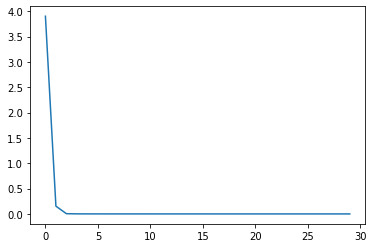

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

**Generating the text**

In [ ]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()
    for p in range(predict_len):

        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        # print(prime_input)
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [ ]:
startwith = 'اين بنظر'
print(evaluate(startwith, 40, temperature=1))

اين بنظر ميرسد اين انفجارهائی هفته گذشته ماه مارس کازابلانکا رخ داد، مشارکت اين سياستها جامعه جهانی همخوانی برقراری روابط مثبت ميان مردم ايران مردم آمريکاو کشورهای ديگر جهان مانع ايجاد ميکند جمهوری خواهان کنگره هفته گذشته موفق تصويب لايحه مشابهی مجلس


How temperature parameter relates to the random parameter in the N-gram example?